## Partie 1 b) Modèle Pytorch

In [26]:
%matplotlib inline  
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
import torchvision.datasets as datasets

In [27]:
train_data = datasets.FashionMNIST('./data-partie-2', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

valid_data = datasets.FashionMNIST('./data-partie-2', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [28]:
train_idx = np.arange(51000)
#train_idx = np.random.choice(train_data.train_data.shape[0], 51000, replace=False)
print(train_idx)

[    0     1     2 ... 50997 50998 50999]


In [29]:
## Prend 51 000 examples pour les données d'entrainement
train_data.data = train_data.train_data[train_idx, :]
train_data.targets = train_data.train_labels[torch.from_numpy(train_idx).type(torch.LongTensor)]

C:\Users\Philippe\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Philippe\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [30]:
mask = np.ones(60000)
mask[train_idx] = 0

In [31]:
## Prend 51 000 examples pour les données d'entrainement
valid_data.data = valid_data.train_data[torch.from_numpy(np.argwhere(mask)), :].squeeze()
valid_data.targets = valid_data.train_labels[torch.from_numpy(mask).type(torch.ByteTensor)]

C:\w\1\s\tmp_conda_3.8_075429\conda\conda-bld\pytorch_1579852542185\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


In [32]:
batch_size = 64
test_batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=False)

valid_loader = torch.utils.data.DataLoader(valid_data,
    batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data-partie-2', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=False)

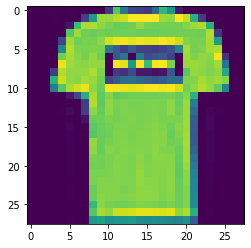

In [33]:
plt.imshow(train_loader.dataset.train_data[1].numpy())

## Architecture Fully Connected

In [34]:
class FcNN(nn.Module):
    def __init__(self, hidden_layers=[300], activation='relu'):
        super().__init__()
        self.number_of_hidden_layers = len(hidden_layers)
        self.h_layer_nodes= hidden_layers[0]
        self.activation = activation
        self.fc1 = nn.Linear(28*28, self.h_layer_nodes)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_layers) - 1):
            self.hidden.append(nn.Linear(self.h_layer_nodes, self.h_layer_nodes))
        self.fc2 = nn.Linear(self.h_layer_nodes, 10)
    
    def forward(self, image):
        batch_size = image.size()[0]
        x = image.view(batch_size, -1)
        if self.activation == "sigmoid" :
            x = F.sigmoid(self.fc1(x))
            if self.number_of_hidden_layers > 0:
                for hidden_layer in self.hidden :
                     x = F.sigmoid(hidden_layer(x))
        elif self.activation == "relu":
            x = F.relu(self.fc1(x))
            if self.number_of_hidden_layers > 0:
               for hidden_layer in self.hidden :
                     x = F.relu(hidden_layer(x))
        elif self.activation == "tanh":
            x = F.tanh(self.fc1(x))
            if self.number_of_hidden_layers > 0:
               for hidden_layer in self.hidden :
                     x = F.tanh(hidden_layer(x))                     
        x = F.log_softmax(self.fc2(x), dim=1)
        return x
    

In [35]:
def train(model, train_loader, optimizer):
    criterion = F.nll_loss
    model.train()
    for batch_idx,(data, target) in enumerate(train_loader):
        data, target = Variable(data).cuda(), Variable(target).cuda()
        optimizer.zero_grad()
        output = model(data)  # calls the forward function
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    return model

def get_loss_and_accuracy(model, data_loader):
    criterion = F.nll_loss
    model.eval()
    loss = 0
    correct = 0
    for data, target in data_loader:
        data, target = Variable(data).cuda(), Variable(target).cuda()
        output = model(data)
        loss += criterion(output, target, reduction="sum").item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
    loss /= len(data_loader.dataset)
    return correct.item() / len(data_loader.dataset), loss 

def valid(model, valid_loader):
    precision, loss = get_loss_and_accuracy(model, valid_loader)
    print('\n' + "valid" + ' set: Average loss: {:.4f}, Accuracy: {:.3f} ({:.0f}%)\n'.format(
        loss, precision,
        100. * precision))
    return precision, loss


def test(model, test_loader, plot_title):
    print("Résultats de test pour l'" + plot_title)
    precision, loss = get_loss_and_accuracy(model, test_loader)
    print('\n' + "test" + ' set: Average loss: {:.4f}, Accuracy: {:.3f} ({:.0f}%)\n'.format(
        loss, precision,
        100. * precision))
    return precision
    
def train_and_evaluate(model, epochs=25, lr=0.001):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    losses= []
    validation_accuracies = []
    for epoch in range(1, epochs + 1):
        model = train(model, train_loader, optimizer)
        train_precision, train_loss = get_loss_and_accuracy(model, train_loader)
        precision, valid_loss = valid(model, valid_loader)
        
        losses.append((train_loss,valid_loss))
        validation_accuracies.append(precision)
    return losses, validation_accuracies, precision

def plotLoss(losses, plot_title):
    loss_type = "Negative log-likelihood"    
    plt.title(loss_type + " loss of a " + plot_title)
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel(loss_type + " loss")
    plt.legend(['training', 'validation'], loc="upper right")
    plt.show()

def plotAccuracy(validation_accuracies, plot_title):
    plt.title("Accuracy of " + plot_title)
    plt.plot(validation_accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend(['validation'], loc="lower right")
    plt.show()

def plotGraphs(losses, validation_accuracies, plot_title):
    plotLoss(losses, plot_title)
    plotAccuracy(validation_accuracies, plot_title)
    


valid set: Average loss: 0.5659, Accuracy: 0.804 (80%)


valid set: Average loss: 0.4886, Accuracy: 0.828 (83%)


valid set: Average loss: 0.4546, Accuracy: 0.840 (84%)


valid set: Average loss: 0.4327, Accuracy: 0.847 (85%)


valid set: Average loss: 0.4167, Accuracy: 0.851 (85%)


valid set: Average loss: 0.4046, Accuracy: 0.856 (86%)


valid set: Average loss: 0.3953, Accuracy: 0.859 (86%)


valid set: Average loss: 0.3877, Accuracy: 0.862 (86%)


valid set: Average loss: 0.3810, Accuracy: 0.864 (86%)


valid set: Average loss: 0.3750, Accuracy: 0.866 (87%)


valid set: Average loss: 0.3698, Accuracy: 0.869 (87%)


valid set: Average loss: 0.3659, Accuracy: 0.871 (87%)


valid set: Average loss: 0.3622, Accuracy: 0.872 (87%)


valid set: Average loss: 0.3581, Accuracy: 0.874 (87%)


valid set: Average loss: 0.3550, Accuracy: 0.875 (87%)


valid set: Average loss: 0.3528, Accuracy: 0.875 (88%)


valid set: Average loss: 0.3507, Accuracy: 0.876 (88%)


valid set: Average loss: 0.348

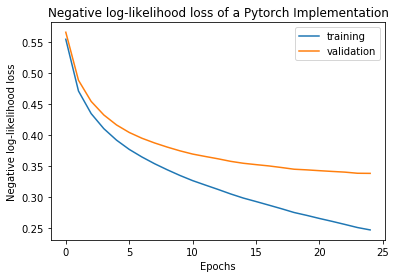

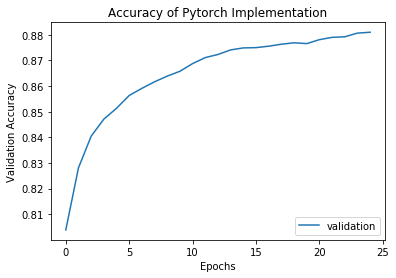

0.8712

In [36]:
from beautifultable import BeautifulTable
model = FcNN([300,300], 'relu')
lr = 0.01
epochs = 25
table = BeautifulTable()
table.column_headers = ["lr", "epochs", "val_accuracy","test_accuracy"]
plot_title = "Pytorch Implementation"
model = model.cuda()
losses, val_accuracies, val_precision = train_and_evaluate(model, epochs, lr)
precision_test = test(model, test_loader, plot_title)
table.append_row([lr, epochs, val_precision,precision_test])
plotGraphs(losses, val_accuracies, plot_title)
print(table)
test(model, test_loader, plot_title)

## Tracage des graphiques de pertes. Necessite l'execution du notebook Partie1_B.ipynb au prealable pour fonctionne

In [37]:
## Récupèrer les loss du Notebook Parti1_B.ipynb
%store -r from_scratch_train_loss
%store -r from_scratch_val_loss
%store -r from_scratch_val_accuracies

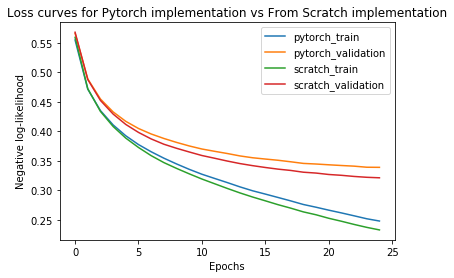

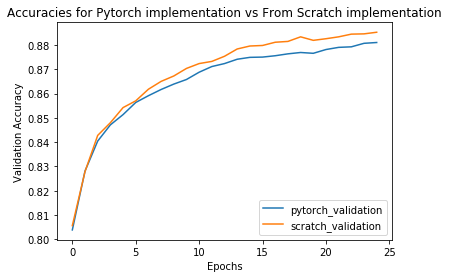

In [38]:
## Fait les graphiques combinant les loss du modele from scratch et du model pytorch
from_scratch_losses = list(zip(from_scratch_train_loss,from_scratch_val_loss))

   
plt.title("Loss curves for Pytorch implementation vs From Scratch implementation")
plt.plot(losses)
plt.plot(from_scratch_losses)
plt.xlabel('Epochs')
plt.ylabel("Negative log-likelihood")
plt.legend(['pytorch_train', 'pytorch_validation', 'scratch_train', 'scratch_validation'], loc="upper right")
plt.show()

plt.title("Accuracies for Pytorch implementation vs From Scratch implementation")
plt.plot(val_accuracies)
plt.plot(from_scratch_val_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend(['pytorch_validation','scratch_validation'], loc="lower right")
plt.show()

[0.5591164038846455, 0.47211715138845556, 0.433520954995847, 0.4079945047297149, 0.388247504282537, 0.37240580006097346, 0.35852708388009064, 0.34679167521767623, 0.3369522300667978, 0.3277198241863926, 0.3189172401623303, 0.31093755341469664, 0.3029744491049039, 0.29536789859448037, 0.28838825915971006, 0.2819739490566902, 0.2754413788044439, 0.26956679741422435, 0.26319956900782665, 0.2583058942421041, 0.25236470613592527, 0.24733285421680282, 0.24193145995850754, 0.2369579847937518, 0.23262898926212858]


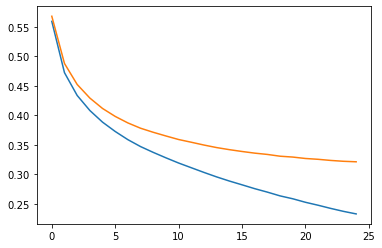

In [39]:
print(from_scratch_train_loss)
plt.plot(from_scratch_train_loss)
plt.plot(from_scratch_val_loss)
